In [229]:
import csv
import math
import operator
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import OrderedDict
from operator import itemgetter 
from mpl_toolkits.mplot3d import axes3d

In [230]:
class Player:
    def __init__(self, pid, mmr, ping, hours):
        self.pid = pid
        self.mmr = mmr
        self.ping = ping
        self.hours = hours
        self.classification = ""
    
    def getPid(self):
        return self.pid
    
    def getMmr(self):
        return self.mmr
    
    def getPing(self):
        return self.ping
    
    def getHours(self):
        return self.hours
    
    def getClassification(self):
        return self.classification
    
    def setClassification(self, classification):
        self.classification = classification
        
    def __str__(self):
        return "Player: " + str(self.pid) + ", " + str(self.mmr) + ", " + str(self.hours)
    
    def __repr__(self):
        return "Player: " + str(self.pid) + ", " + str(self.mmr) + ", " + str(self.hours)

In [231]:
def getAllPlayersFromCsv():
    players = []
    counter = 0 
    with open('data.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[1] == 'LeagueIndex':
                continue
            # Adding noise to the MMR since the MMR was unrealistic
            noise = np.random.uniform(-1, 1)
            # Skip a bad value in the data
            if (row[4] == "?"):
                continue
            player = Player("p" + str(counter) + ".", float(row[1]) + noise, float(row[13]), float(row[4]))
            players.append(player)
            counter += 1
    return players

In [240]:
def getScatterData(players):
    xCoords = []
    yCoords = []
    zCoords = []
    for player in players:
        xCoords.append(player.getMmr())
        yCoords.append(player.getPing())
        zCoords.append(player.getHours())
        
    return xCoords, yCoords, zCoords

def plotScatter(players):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax = fig.gca(projection='3d')
    
    colors = []
    for player in players:
        if player.getClassification() == "new":
            colors.append("red")
        else:
            colors.append("blue")
    
    xCoords, yCoords, zCoords = getScatterData(players)
    ax.scatter(xCoords, yCoords, zCoords, c=colors)
    plt.show()

In [241]:
def euclideanDistance(player1, player2):
    distance = 0
    distance += (player1.getMmr() - player2.getMmr())**2
    distance += (player1.getPing() - player2.getPing())**2
    distance += (player1.getHours() - player2.getHours())**2
    return math.sqrt(distance)

def getNeighbors(trainingPlayerSet, testPlayer, k):
    distances = []
    for i in range(len(trainingPlayerSet)):
        dist = euclideanDistance(testPlayer, trainingPlayerSet[i])
        distances.append((trainingPlayerSet[i], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

def getResponse(neighbors):
    classificationVotes = {}
    for i in range(len(neighbors)):
        response = neighbors[i].getClassification()
        if response in classificationVotes:
            classificationVotes[response] += 1
        else:
            classificationVotes[response] = 1
    
    rankedClassification = [(neighbor, classificationVotes[neighbor]) for neighbor in sorted(classificationVotes, key=classificationVotes.get, reverse=True)]
    
    # Take the first, highest classification (if tie happens, it will take the first occurence)
    for classification, votes in rankedClassification:
        return classification

In [242]:
def detClassification(players):
    for player in players:
        if player.getHours() < 100 and player.getMmr() < 3:
            player.setClassification("new")
        else:
            player.setClassification("old")
            
def splitPlayersTestTrain(players):
    random.shuffle(players)
    firstThird = int(len(players) * 0.33)
    trainingPlayers = players[0:firstThird]
    testPlayers = players[firstThird:-1]
    
    detClassification(trainingPlayers)
    neighbors = getNeighbors(trainingPlayers, testPlayers[0], 2)
    
    return testPlayers, trainingPlayers

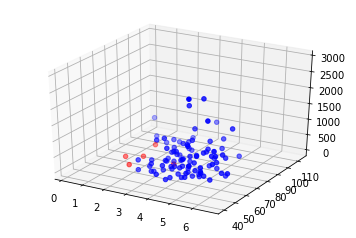

In [244]:
def main():
    MIN_SIMILARITY = 5
    
    # Get all of the test player data
    players = getAllPlayersFromCsv()

    # Split the players into a test set and training set
    testPlayers, trainingPlayers = splitPlayersTestTrain(players)
        
    # Determine the classification for the test players
    k = 2
    for i in range(len(testPlayers)):
        neighbors = getNeighbors(trainingPlayers, testPlayers[i], k)
        result = getResponse(neighbors)
        testPlayers[i].setClassification(result)
    
    plotScatter(testPlayers[0:100])
    
main()